In [4]:
from dask.diagnostics import ProgressBar
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from datatree import DataTree

import valenspy as vp

/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_env/lib/python3.11/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


# MAR IC tests

In [11]:
ds_mar = xr.open_dataset("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc44757_Nicolas/remap_mar/MARv3.14-ERA51983_BE_regridded.nc")

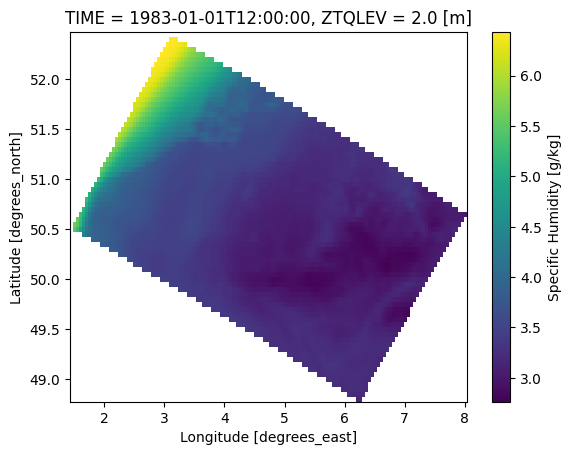

In [12]:
ds_mar.QQZ.isel(TIME=0).plot()

In [13]:
mar_ic = vp.input.INPUT_CONVERTORS["MAR"]
ds_mar = mar_ic.convert_input(ds_mar)

Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
78.57% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas', 'huss', 'hurs', 'uas', 'vas', 'rsds', 'clt', 'tasmax', 'tasmin', 'prsn', 'pr']
Unknown to ValEnsPy: ['TIME_bnds', 'ZUVLEV_bnds', 'RHZmin']


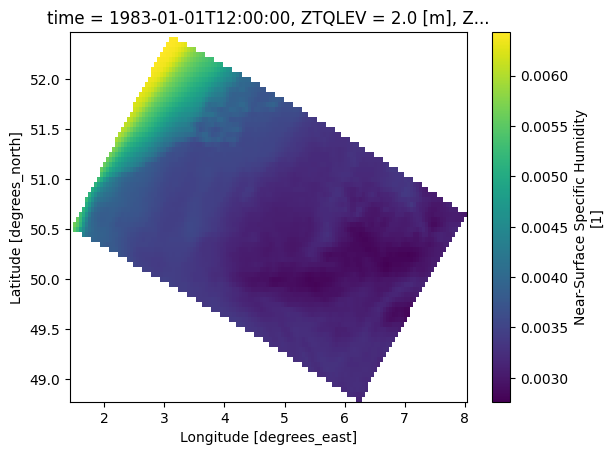

In [9]:
ds_mar.huss.isel(time=0).plot()

In [16]:
variables = ["tas", "pr"]
manager = vp.InputManager(machine="hortense")
ds_ref = manager.load_data("CLIMATE_GRID", variables, path_identifiers=["regridded"])

File paths found:
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/PRECIP_QUANTITY_CLIMATE_GRID_1951_2023_daily_latlon_5km.nc
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/TEMP_AVG_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr', 'tas']


In [18]:
help(vp.remap_xesmf)

Help on function remap_xesmf in module valenspy.processing.regrid:

remap_xesmf(ds, ds_out, method='bilinear', regridder_kwargs={}, regridding_kwargs={})
    Remap the input dataset to the target grid using xESMF.
    
    Parameters
    ----------
    ds : xarray.Dataset
        The input dataset to remap.
    ds_out : xarray.Dataset
        The target grid dataset.
    method : str, optional
        The remap method to use, by default "bilinear".
    regridder_kwargs : dict
        Keyword arguments for the creation of the regridder. See xe.Regridder for more information.
    regridding_kwargs : dict
        Keyword arguments for the actual regridding. See xe.Regridder.regrid_dataset() for more information.
    
    Returns
    -------
    xarray.Dataset
        The remapped dataset in xarray format.



In [19]:
ds_mar_regridded = vp.remap_xesmf(ds_mar, ds_ref, method="conservative", regridding_kwargs={"keep_attrs": True})

In [21]:
ds_mar

<xarray.Dataset> Size: 171MB
Dimensions:      (time: 365, bnds: 2, lon: 132, lat: 74)
Coordinates:
  * time         (time) datetime64[ns] 3kB 1983-01-01T12:00:00 ... 1983-12-31...
  * lon          (lon) float64 1kB 1.46 1.51 1.56 1.61 ... 7.86 7.91 7.96 8.01
  * lat          (lat) float64 592B 52.45 52.4 52.35 52.3 ... 48.9 48.85 48.8
    ZTQLEV       float32 4B 2.0
    ZUVLEV       float32 4B 2.0
Dimensions without coordinates: bnds
Data variables: (12/14)
    TIME_bnds    (time, bnds) datetime64[ns] 6kB ...
    ZUVLEV_bnds  (bnds) float32 8B ...
    tas          (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    huss         (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    hurs         (time, lat, lon) float32 14MB ...
    uas          (time, lat, lon) float32 14MB ...
    ...           ...
    clt          (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    tasmax       (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    tasmin       (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    RHZmin       (time, lat, lon) float32 14MB ...
    prsn         (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institute:    University of Liège (Belgium)
    contact:      xavierfettweis@uliege.be
    model:        regional climate model MARv3.13
    NCO:          netCDF Operators version 5.2.4 (Homepage = http://nco.sf.ne...
    history:      Thu Feb 06 16:51:44 2025: cdo remapbil,gridoutput MARv3.14-...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...
    dataset:      MAR
    freq:         day
    region:       Belgium

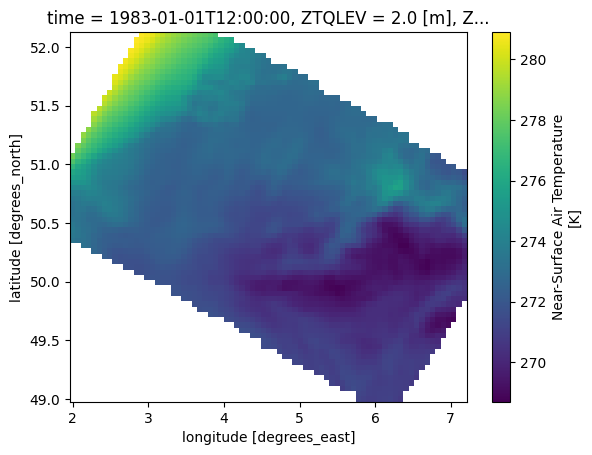

In [20]:
ds_mar_regridded.isel(time=0).tas.plot()

In [22]:
from valenspy.diagnostic import SpatialBias

bias = SpatialBias(ds_mar_regridded.sel(time=slice("1983-01-01", "1983-12-31")), ds_ref.sel(time=slice("1983-01-01", "1983-12-31")))


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_env/lib/python3.11/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable has a non-conforming cell_methods: Got `TIME: mean`, which do not include the expected `time: minimum`.
  _check_cell_methods(


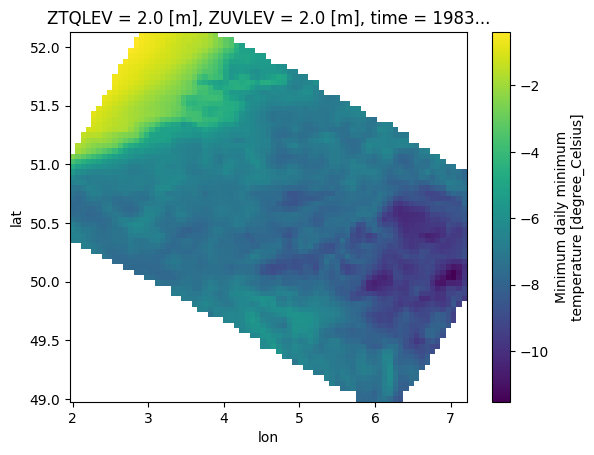

In [28]:
import xclim
xclim.indicators.cf.tnn(ds_mar_regridded.tasmin, freq="YS").plot()

<Axes: title={'center': 'Spatial Bias'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

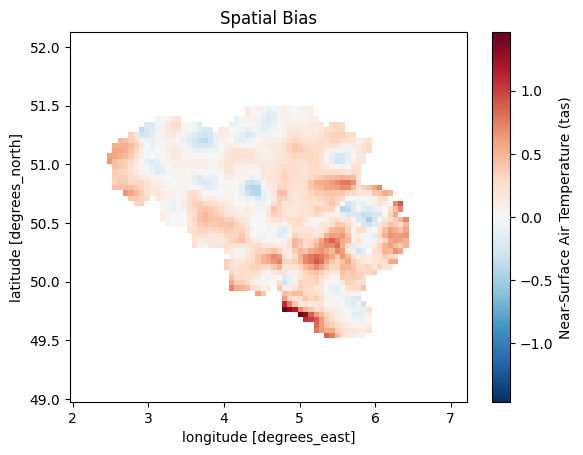

In [25]:
#Why does SpatialBias need name (to be investigated later...)
bias.attrs["name"]="MAR"
SpatialBias.plot(bias.tas)

<Axes: title={'center': 'Spatial Bias'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

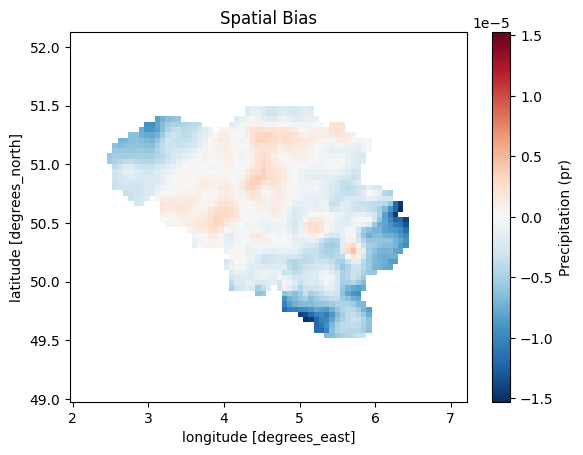

In [26]:
SpatialBias.plot(bias.pr)

# Other ICs

In [2]:
manager = vp.InputManager("hortense")

In [ ]:
experiment = "CB2_CCLM_BEL28_ERA5_evaluation"
ds_cclm_tas     = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "mean"])
ds_cclm_tasmax  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "max"]).rename({'tas':'tasmax'})
ds_cclm_tasmin  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "min"]).rename({'tas':'tasmin'})
ds_cclm_pr      = manager.load_data("CCLM", ["pr"], freq="daily", path_identifiers=[experiment, "sum"])

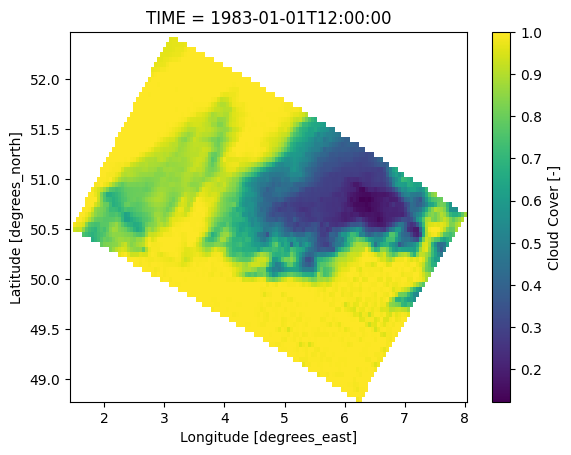

In [6]:
ds_mar.isel(TIME=0).CC.plot()

In [21]:
ds_mar

<xarray.Dataset> Size: 171MB
Dimensions:      (TIME: 365, bnds: 2, lon: 132, lat: 74, ZTQLEV: 1, ZUVLEV: 1)
Coordinates:
  * TIME         (TIME) datetime64[ns] 3kB 1983-01-01T12:00:00 ... 1983-12-31...
  * lon          (lon) float64 1kB 1.46 1.51 1.56 1.61 ... 7.86 7.91 7.96 8.01
  * lat          (lat) float64 592B 52.45 52.4 52.35 52.3 ... 48.9 48.85 48.8
  * ZTQLEV       (ZTQLEV) float32 4B 2.0
  * ZUVLEV       (ZUVLEV) float32 4B 2.0
Dimensions without coordinates: bnds
Data variables: (12/14)
    TIME_bnds    (TIME, bnds) datetime64[ns] 6kB ...
    ZUVLEV_bnds  (ZUVLEV, bnds) float32 8B ...
    TTZ          (TIME, ZTQLEV, lat, lon) float32 14MB ...
    QQZ          (TIME, ZTQLEV, lat, lon) float32 14MB ...
    RHZ          (TIME, ZTQLEV, lat, lon) float32 14MB ...
    U2Z          (TIME, ZUVLEV, lat, lon) float32 14MB ...
    ...           ...
    CC           (TIME, lat, lon) float32 14MB ...
    TTZmax       (TIME, ZTQLEV, lat, lon) float32 14MB ...
    TTZmin       (TIME, ZTQLEV, lat, lon) float32 14MB ...
    RHZmin       (TIME, ZTQLEV, lat, lon) float32 14MB ...
    MBSF         (TIME, lat, lon) float32 14MB ...
    MBRR         (TIME, lat, lon) float32 14MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institute:    University of Liège (Belgium)
    contact:      xavierfettweis@uliege.be
    model:        regional climate model MARv3.13
    NCO:          netCDF Operators version 5.2.4 (Homepage = http://nco.sf.ne...
    history:      Thu Feb 06 16:51:44 2025: cdo remapbil,gridoutput MARv3.14-...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [22]:
ds_mar.isel(ZTQLEV=0,ZUVLEV=0)

<xarray.Dataset> Size: 171MB
Dimensions:      (TIME: 365, bnds: 2, lon: 132, lat: 74)
Coordinates:
  * TIME         (TIME) datetime64[ns] 3kB 1983-01-01T12:00:00 ... 1983-12-31...
  * lon          (lon) float64 1kB 1.46 1.51 1.56 1.61 ... 7.86 7.91 7.96 8.01
  * lat          (lat) float64 592B 52.45 52.4 52.35 52.3 ... 48.9 48.85 48.8
    ZTQLEV       float32 4B 2.0
    ZUVLEV       float32 4B 2.0
Dimensions without coordinates: bnds
Data variables: (12/14)
    TIME_bnds    (TIME, bnds) datetime64[ns] 6kB ...
    ZUVLEV_bnds  (bnds) float32 8B ...
    TTZ          (TIME, lat, lon) float32 14MB ...
    QQZ          (TIME, lat, lon) float32 14MB ...
    RHZ          (TIME, lat, lon) float32 14MB ...
    U2Z          (TIME, lat, lon) float32 14MB ...
    ...           ...
    CC           (TIME, lat, lon) float32 14MB ...
    TTZmax       (TIME, lat, lon) float32 14MB ...
    TTZmin       (TIME, lat, lon) float32 14MB ...
    RHZmin       (TIME, lat, lon) float32 14MB ...
    MBSF         (TIME, lat, lon) float32 14MB ...
    MBRR         (TIME, lat, lon) float32 14MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institute:    University of Liège (Belgium)
    contact:      xavierfettweis@uliege.be
    model:        regional climate model MARv3.13
    NCO:          netCDF Operators version 5.2.4 (Homepage = http://nco.sf.ne...
    history:      Thu Feb 06 16:51:44 2025: cdo remapbil,gridoutput MARv3.14-...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [24]:
mar_ic = vp.InputConverter("MAR_lookup", mar_to_CF, {})

In [25]:
ds_mar_c = mar_ic.convert_input(ds_mar, metadata_info={"source":"MAR"})
ds_mar_c

Variable metadata is missing or incorrect
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
71.43% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas', 'hurs', 'uas', 'vas', 'rsds', 'clt', 'tasmax', 'tasmin', 'prsn', 'pr']
NOT ValEnsPy CF compliant: ['huss']
Unknown to ValEnsPy: ['TIME_bnds', 'ZUVLEV_bnds', 'RHZmin']
The following attributes are missing or incorrect for the variable huss:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           1                                                  


<xarray.Dataset> Size: 171MB
Dimensions:      (time: 365, bnds: 2, lon: 132, lat: 74)
Coordinates:
  * time         (time) datetime64[ns] 3kB 1983-01-01T12:00:00 ... 1983-12-31...
  * lon          (lon) float64 1kB 1.46 1.51 1.56 1.61 ... 7.86 7.91 7.96 8.01
  * lat          (lat) float64 592B 52.45 52.4 52.35 52.3 ... 48.9 48.85 48.8
    ZTQLEV       float32 4B 2.0
    ZUVLEV       float32 4B 2.0
Dimensions without coordinates: bnds
Data variables: (12/14)
    TIME_bnds    (time, bnds) datetime64[ns] 6kB ...
    ZUVLEV_bnds  (bnds) float32 8B ...
    tas          (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    huss         (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    hurs         (time, lat, lon) float32 14MB ...
    uas          (time, lat, lon) float32 14MB ...
    ...           ...
    clt          (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    tasmax       (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    tasmin       (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    RHZmin       (time, lat, lon) float32 14MB ...
    prsn         (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float32 14MB nan nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institute:    University of Liège (Belgium)
    contact:      xavierfettweis@uliege.be
    model:        regional climate model MARv3.13
    NCO:          netCDF Operators version 5.2.4 (Homepage = http://nco.sf.ne...
    history:      Thu Feb 06 16:51:44 2025: cdo remapbil,gridoutput MARv3.14-...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...
    source:       MAR

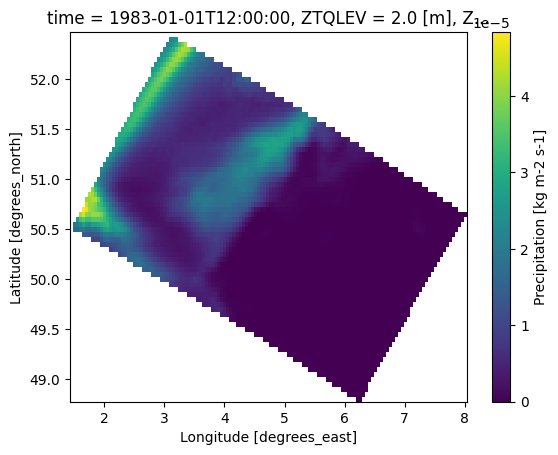

In [27]:
ds_mar_c.pr.isel(time=0).plot()

In [10]:
ds_mar.drop_dims(drop_dims=["ZTQLEV", "ZUVLEV"])

<xarray.Dataset> Size: 57MB
Dimensions:    (TIME: 365, bnds: 2, lon: 132, lat: 74)
Coordinates:
  * TIME       (TIME) datetime64[ns] 3kB 1983-01-01T12:00:00 ... 1983-12-31T1...
  * lon        (lon) float64 1kB 1.46 1.51 1.56 1.61 ... 7.86 7.91 7.96 8.01
  * lat        (lat) float64 592B 52.45 52.4 52.35 52.3 ... 48.9 48.85 48.8
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds  (TIME, bnds) datetime64[ns] 6kB ...
    SWD        (TIME, lat, lon) float32 14MB ...
    CC         (TIME, lat, lon) float32 14MB ...
    MBSF       (TIME, lat, lon) float32 14MB ...
    MBRR       (TIME, lat, lon) float32 14MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institute:    University of Liège (Belgium)
    contact:      xavierfettweis@uliege.be
    model:        regional climate model MARv3.13
    NCO:          netCDF Operators version 5.2.4 (Homepage = http://nco.sf.ne...
    history:      Thu Feb 06 16:51:44 2025: cdo remapbil,gridoutput MARv3.14-...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [9]:
ds_mar

<xarray.Dataset> Size: 171MB
Dimensions:      (TIME: 365, bnds: 2, lon: 132, lat: 74, ZTQLEV: 1, ZUVLEV: 1)
Coordinates:
  * TIME         (TIME) datetime64[ns] 3kB 1983-01-01T12:00:00 ... 1983-12-31...
  * lon          (lon) float64 1kB 1.46 1.51 1.56 1.61 ... 7.86 7.91 7.96 8.01
  * lat          (lat) float64 592B 52.45 52.4 52.35 52.3 ... 48.9 48.85 48.8
  * ZTQLEV       (ZTQLEV) float32 4B 2.0
  * ZUVLEV       (ZUVLEV) float32 4B 2.0
Dimensions without coordinates: bnds
Data variables: (12/14)
    TIME_bnds    (TIME, bnds) datetime64[ns] 6kB ...
    ZUVLEV_bnds  (ZUVLEV, bnds) float32 8B ...
    TTZ          (TIME, ZTQLEV, lat, lon) float32 14MB ...
    QQZ          (TIME, ZTQLEV, lat, lon) float32 14MB ...
    RHZ          (TIME, ZTQLEV, lat, lon) float32 14MB ...
    U2Z          (TIME, ZUVLEV, lat, lon) float32 14MB ...
    ...           ...
    CC           (TIME, lat, lon) float32 14MB ...
    TTZmax       (TIME, ZTQLEV, lat, lon) float32 14MB ...
    TTZmin       (TIME, ZTQLEV, lat, lon) float32 14MB ...
    RHZmin       (TIME, ZTQLEV, lat, lon) float32 14MB ...
    MBSF         (TIME, lat, lon) float32 14MB ...
    MBRR         (TIME, lat, lon) float32 14MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institute:    University of Liège (Belgium)
    contact:      xavierfettweis@uliege.be
    model:        regional climate model MARv3.13
    NCO:          netCDF Operators version 5.2.4 (Homepage = http://nco.sf.ne...
    history:      Thu Feb 06 16:51:44 2025: cdo remapbil,gridoutput MARv3.14-...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

TypeError: Dataset.drop_dims() got an unexpected keyword argument 'dims'

In [ ]:
mar_dict = {
    "tas": 
    
}

In [ ]:
ds_cclm_pr.isel(time=0).pr.plot()

In [ ]:
import xclim
xclim.indicators.cf.tnn(ds_cclm_tas.tas, freq='YS')

In [4]:
ds_era5 = manager.load_data("ERA5",["tas"], period=[2000],freq="daily",region="europe", path_identifiers=["min"])
ds_era5

File paths found:
/dodrio/scratch/projects/2022_200/external/era5/europe/2m_temperature/daily/2m_temperature_era5_europe_daily_min_2000.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds']


In [ ]:
variables = ["tas", "pr"]
ds_ref = manager.load_data("CLIMATE_GRID", variables, path_identifiers=["regridded"])
ds_ref

File paths found:
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/TEMP_AVG_CLIMATE_GRID_1954_2023_daily_latlon_5km.nc
/dodrio/scratch/projects/2022_200/external/climate_grid/regridded/latlon_5km/PRECIP_QUANTITY_CLIMATE_GRID_1951_2023_daily_latlon_5km.nc


The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['pr', 'tas']
